In [1]:
using Plots
using Statistics
using StatsBase
using LaTeXStrings

using LightGraphs, SimpleWeightedGraphs
using GraphPlot
using Compose

using LinearAlgebra

# Functions 

In [148]:
function init_WS(N, k, beta, param, prob="Uniform")
   
    G = watts_strogatz(N, k, beta)
    
    G_weighted = SimpleWeightedGraph(N)
    
    if prob == "Power-law"

        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), 1 * (1-rand())^(-1/(param-1)))

        end
        
    elseif prob == "Uniform"
        
        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), mean([2 * rand() for i in 1 : param]))

        end
        
    elseif prob == "Gaussian"
        
        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), param + randn())

        end
        
    else
        
        println("Probability distribution not implemented")
        
    end
    
    return G_weighted
    
end

function init_BA(N, k, param, prob="Uniform")
   
    G = barabasi_albert(N, k)
    
    G_weighted = SimpleWeightedGraph(N)
    
    if prob == "Power-law"

        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), 1 * (1-rand())^(-1/(param-1)))

        end
        
    elseif prob == "Uniform"
        
        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), mean([2 * rand() for i in 1 : param]))

        end
        
    elseif prob == "Gaussian"
        
        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), param + randn())

        end
        
    else
        
        println("Probability distribution not implemented")
        
    end
    
    return G_weighted
    
end

#Random configuration model
function init_RCM(N, k, param, prob="Uniform")
   
    G = random_configuration_model(N, [k for i in 1 : N])
    
    G_weighted = SimpleWeightedGraph(N)
    
    if prob == "Power-law"

        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), 1 * (1-rand())^(-1/(param-1)))

        end
        
    elseif prob == "Uniform"
        
        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), mean([2 * rand() for i in 1 : param]))

        end
        
    elseif prob == "Gaussian"
        
        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), 10 + param*randn())

        end
        
    else
        
        println("Probability distribution not implemented")
        
    end
    
    return G_weighted
    
end

function set_node_states(N, N_inf)
    
    node_type = zeros(N)
    
    rand_nodes = sample(1 : N, N_inf, replace=false)

    for i in 1 : N_inf
        
        r = rand_nodes[i]
    
        node_type[r] = 1
        
    end
    
    return node_type
    
end

function MC_SIS(G, node_dic, lambda, mu)
    
    infected_nodes = []
    susceptible_nodes = []
    
    for node in vertices(G)
    
        if node_dic[node] == 1 #Infected node

            neighbours = neighbors(G, node)
            
            #The infected node can infect each of its neighbours with probability proportional
            #to the edge weights
            edge_w = [G.weights[node, nn] for nn in neighbours]
            
            selected = sample(neighbours, Weights(edge_w)) #No need to normalise weights.
            #selected = rand(neighbours)
            
            #Infect selected node the next time step (if it was already infected nothing happens)
            if rand() < lambda
                append!(infected_nodes, selected)
            end
                
            #Infected node gets recovered with probability mu
            if rand() < mu

                append!(susceptible_nodes, node)

            end

        end

    end
    
    
    for item in infected_nodes
        
        node_dic[item] = 1
        
    end
    
    for item in susceptible_nodes
        
        node_dic[item] = 0
        
    end
    
    return node_dic
    
end

function MC_SIS_rand(G, node_dic, lambda, mu)
    
    infected_nodes = []
    susceptible_nodes = []
    
    for node in vertices(G)
    
        if node_dic[node] == 1 #Infected node

            neighbours = neighbors(G, node)
            
            #The infected node can infect each of its neighbours with probability proportional
            #to the edge weights
            edge_w = [G.weights[node, nn] for nn in neighbours]
            
            selected = rand(neighbours)
            
            #Infect selected node the next time step (if it was already infected nothing happens)
            if rand() < lambda
                append!(infected_nodes, selected)
            end
                
            #Infected node gets recovered with probability mu
            if rand() < mu

                append!(susceptible_nodes, node)

            end

        end

    end
    
    
    for item in infected_nodes
        
        node_dic[item] = 1
        
    end
    
    for item in susceptible_nodes
        
        node_dic[item] = 0
        
    end
    
    return node_dic
    
end


function compute_observables(G, node_dic)
   
    S = 0
    I = 0
    R = 0
    
    for node in vertices(G)
    
        if node_dic[node] == 0
            
            S += 1
            
        elseif node_dic[node] == 1
            
            I += 1
            
        else
            
            R += 1
            
        end
        
    end
    
    return S / nv(G), I / nv(G), R / nv(G)
    
end

function compute_edge_density(G, node_dic, discr)
    
    E_SI = zeros(length(discr) - 1)
    E_SS = zeros(length(discr) - 1)
    E_II = zeros(length(discr) - 1)
   
    for edge in collect(edges(G))
        
        for i in 2 : length(discr)
            
            if weight(edge) < discr[i]
       
                if node_dic[src(edge)] != node_dic[dst(edge)]

                    E_SI[i-1] += 1

                else

                    if node_dic[src(edge)] == 0

                        E_SS[i-1] += 1

                    else

                        E_II[i-1] += 1

                    end

                end
                
            end
            
        end
        
    end
    
    normalisation = [E_SI[i] + E_SS[i] + E_II[i] for i in 1 : length(discr)-1]
    
    return E_SI ./ normalisation , E_SS ./ normalisation, E_II ./ normalisation
    
end

function SIS_model_WS(N, N_inf, k, beta, param, lambda, mu, t, times, prob="Uniform")
    
    S = zeros(t)
    I = zeros(t)
    
    for index in 1 : times
        
        G = init_WS(N, k, beta, param, prob)
                
        node_dic = set_node_states(N, N_inf)        
    
        for i in 1 : t
            
            obs = compute_observables(G, node_dic)
            
            S[i] += obs[1]
            I[i] += obs[2]
            
            node_dic = MC_SIS(G, node_dic, lambda, mu)

        end
        
    end
    
    return S ./ times, I ./ times
    
end

function SIS_model_BA(N, N_inf, k, param, lambda, mu, t, times, prob="Uniform")
    
    S = zeros(t)
    I = zeros(t)
    
    for index in 1 : times
        
        G = init_BA(N, k, param, prob)
                
        node_dic = set_node_states(N, N_inf)        
    
        for i in 1 : t
            
            obs = compute_observables(G, node_dic)
            
            S[i] += obs[1]
            I[i] += obs[2]
            
            node_dic = MC_SIS(G, node_dic, lambda, mu)

        end
        
    end
    
    return S ./ times, I ./ times
    
end

function SIS_model_BA_rand(N, N_inf, k, param, lambda, mu, t, times, prob="Uniform")
    
    S = zeros(t)
    I = zeros(t)
    
    for index in 1 : times
        
        G = init_BA(N, k, param, prob)
                
        node_dic = set_node_states(N, N_inf)        
    
        for i in 1 : t
            
            obs = compute_observables(G, node_dic)
            
            S[i] += obs[1]
            I[i] += obs[2]
            
            node_dic = MC_SIS_rand(G, node_dic, lambda, mu)

        end
        
    end
    
    return S ./ times, I ./ times
    
end

function SIS_model_RCM(N, N_inf, k, param, lambda, mu, t, times, prob="Uniform")
    
    S = zeros(t)
    I = zeros(t)
    
    for index in 1 : times
        
        G = init_RCM(N, k, param, prob)
                
        node_dic = set_node_states(N, N_inf)        
    
        for i in 1 : t
            
            obs = compute_observables(G, node_dic)
            
            S[i] += obs[1]
            I[i] += obs[2]
            
            node_dic = MC_SIS(G, node_dic, lambda, mu)

        end
        
    end
    
    return S ./ times, I ./ times
    
end

function SIS_model_RCM_rand(N, N_inf, k, param, lambda, mu, t, times, prob="Uniform")
    
    S = zeros(t)
    I = zeros(t)
    
    for index in 1 : times
        
        G = init_RCM(N, k, param, prob)
                
        node_dic = set_node_states(N, N_inf)        
    
        for i in 1 : t
            
            obs = compute_observables(G, node_dic)
            
            S[i] += obs[1]
            I[i] += obs[2]
            
            node_dic = MC_SIS_rand(G, node_dic, lambda, mu)

        end
        
    end
    
    return S ./ times, I ./ times
    
end

SIS_model_RCM_rand (generic function with 2 methods)

# Auxiliar functions 

In [105]:
function plot_p_w()
    
    y_1 = [mean([2 * rand() for i in 1 : 1]) for j in 1 : 10^6]
    y_2 = [mean([2 * rand() for i in 1 : 4]) for j in 1 : 10^6]
    y_3 = [mean([2 * rand() for i in 1 : 7]) for j in 1 : 10^6]
    y_4 = [mean([2 * rand() for i in 1 : 10]) for j in 1 : 10^6]

    h_1 = fit(Histogram, y_1, 0:0.01:2)
    h_1 = normalize(h_1, mode=:probability)

    h_2 = fit(Histogram, y_2, 0:0.01:2)
    h_2 = normalize(h_2, mode=:probability)

    h_3 = fit(Histogram, y_3, 0:0.01:2)
    h_3 = normalize(h_3, mode=:probability)

    h_4 = fit(Histogram, y_4, 0:0.01:2)
    h_4 = normalize(h_4, mode=:probability)

    x = range(0, stop=2, length=length(h_4.weights))

    plot(x, h_1.weights, m=:circle, label=L"$n=1$")
    plot!(x, h_2.weights, m=:circle, label=L"$n=4$")
    plot!(x, h_3.weights, m=:circle, label=L"$n=7$")
    plot!(x, h_4.weights, m=:circle, label=L"$n=10$")

    plot!(size=(800, 400), xlabel=L"$\omega$", ylabel=L"$p(\omega)$", guidefont=12, legendfont=12)

    #savefig("p_w_1.png")
    
end

function plot_powerlaw()
    x = [1 * (1-rand())^(-1/(2-1)) for i in 1 : 10^7]
    y = [1 * (1-rand())^(-1/(3-1)) for i in 1 : 10^7]
    z = [1 * (1-rand())^(-1/(4-1)) for i in 1 : 10^7]

    h_x = fit(Histogram, x, 1 : 1 :10^3)
    h_y = fit(Histogram, y, 1 : 1 :10^3)
    h_z = fit(Histogram, z, 1 : 1 :10^3)

    plot(h_x.weights[h_x.weights .> 0], m=:circle, xscale=:log10, yscale=:log10, label=L"$\gamma=2$")
    plot!(h_y.weights[h_y.weights .> 0], m=:circle, xscale=:log10, yscale=:log10, label=L"$\gamma=3$")
    plot!(h_z.weights[h_z.weights .> 0], m=:circle, xscale=:log10, yscale=:log10, label=L"$\gamma=4$")

    plot!(size=(800, 400), xlabel=L"$\omega$", ylabel=L"$p(\omega)$", guidefont=12, legendfont=12)

    #savefig("p_w_powerlaw.png")
    
end

function param_study_RCM(params, N, N_inf, k, lambda, mu, t, times, prob, filename)
    
    prevalence = zeros(length(params))
    error = zeros(length(params))
    
    f = open(filename, "w")
    
    println(f, "#param\tI\terror")
    
    i = 0
    
    for param in params
        
        i += 1
        
        If = zeros(times)

        for index in 1 : times

            G = init_RCM(N, k, param, prob)

            node_dic = set_node_states(N, N_inf)        

            for i in 1 : t

                node_dic = MC_SIS(G, node_dic, lambda, mu)

            end
            
            #Compute only final state
            obs = compute_observables(G, node_dic)
            
            If[index] += obs[2]
            #If_s += obs[2]^2

        end
        
        #avg = If / times
        #sigma = If_s/times - avg^2
        
        prevalence[i] = mean(If)
        error[i] = std(If)
        
        println(f, param, "\t", prevalence[i], "\t", error[i])
        
    end     
    
    close(f)
    
    return prevalence, error
    
end

function edge_density_study_RCM(discr, N, N_inf, k, param, lambda, mu, t, times, prob="Uniform")
    
    E_SI = zeros(length(discr) - 1)
    E_SS = zeros(length(discr) - 1)
    E_II = zeros(length(discr) - 1)

    for index in 1 : times

        G = init_RCM(N, k, param, prob)

        node_dic = set_node_states(N, N_inf)        

        for i in 1 : t

            node_dic = MC_SIS(G, node_dic, lambda, mu)

        end
    
        #Compute edge density in steady state
        obs = compute_edge_density(G, node_dic, discr)
        
        E_SI += obs[1]
        E_SS += obs[2]
        E_II += obs[3]
        
    end
    
    E_SI = E_SI ./ times
    
    E_SS = E_SS ./ times
    
    E_II = E_II ./ times
    
    f = open("edge_density_study_$prob.txt", "w")
    
    println(f, "#w\tE_SI\tE_SS\tE_II")
    
    for i in 1 : length(E_SI)
        
        println(f, discr[i], "\t", E_SI[i], "\t", E_SS[i], "\t", E_II[i])
        
    end
        
    close(f)
    
    return E_SI, E_SS, E_II

end

function difference_study_RCM(ks, N, N_inf, param, lambda, mu, t, times, prob="Uniform")
    
    diff = zeros(length(ks))
    
    f = open("difference_study_RCM.txt", "w")
    
    println(f, "#k\tdiff")
    
    i = 0
    
    @inbounds for k in ks
        
        i += 1
        
        S_r, I_r = SIS_model_RCM_rand(N, N_inf, k, param, lambda, mu, t, times, prob)
        
        S, I = SIS_model_RCM(N, N_inf, k, param, lambda, mu, t, times, prob)
        
        diff[i] = I_r[end] - I[end]
        
        println(f, k, "\t", diff[i])
        
    end
    
    close(f)
    
    return diff
    
end

function difference_study_BA(ks, N, N_inf, param, lambda, mu, t, times, prob="Uniform")
    
    diff = zeros(length(ks))
    
    f = open("difference_study_BA.txt", "w")
    
    println(f, "#k\tdiff")
    
    i = 0
    
    @inbounds for k in ks
        
        i += 1
        
        S_r, I_r = SIS_model_BA_rand(N, N_inf, k, param, lambda, mu, t, times, prob)
        
        S, I = SIS_model_BA(N, N_inf, k, param, lambda, mu, t, times, prob)
        
        diff[i] = I_r[end] - I[end]
        
        println(f, k, "\t", diff[i])
        
    end
    
    close(f)
    
    return diff
    
end

difference_study_BA (generic function with 2 methods)

In [157]:
N = 10^3

N_inf = 10

k = 5

param = 15

lambda = 0.2
mu = 0.1

t = 400
times = 100

prob = "Gaussian"

S, I = @time SIS_model_RCM(N, N_inf, k, param, lambda, mu, t, times, prob);

  6.257384 seconds (172.13 M allocations: 2.399 GiB, 13.85% gc time)


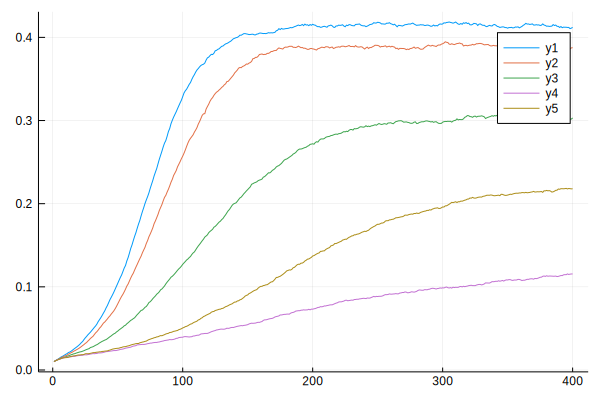

In [158]:
plot!(I)

In [ ]:
ks = 2 : 1 : 5

diff = @time difference_study_BA(ks, N, N_inf, param, lambda, mu, t, times, prob);